## **Overview**

This notebook shows the usage of Keras tuner to find the optimal set of hyperparameters.

For keras tuner see https://www.tensorflow.org/tutorials/keras/keras_tuner

https://keras.io/guides/keras_tuner/getting_started/

We will be working with the [Gluon dataset](https://github.com/rabah-khalek/TF_tutorials/tree/master/PseudoData). A gluon is an elementary particle which gives rise to the strong force, which is the force responsible for binding together the protons and neutrons together in atomic nuclei.

The gluon is exchanged by other elementary particles in the proton and neutron called quarks. These quarks and gluons are more generally referred to as "partons".

Because of certain physical properties governing the partons, they cannot be observed by expermiments as free particles, and their distribution within the proton and neutron cannot be calculated analytically. Instead, their distribution must be inferred from data collected by high energy particle colliders like the Large Hadron Collider (LHC) at CERN.

A fast-moving proton can be described by the parton distribution function (PDF) $f(x)$, which gives the probability density of finding a parton of type $f$ (a specific quark type or gluon) carrying a fraction $x$ of the proton momentum.

The pseudodata used in this tutorial is generated from a gluon distribution function $g(x)$, which was determined in an analysis by the [NNPDF collaboration](http://nnpdf.mi.infn.it), aiming to extract the structure of the proton using contemporary machine learning methods. More specifically, NNPDF determines PDFs using neural networks as a minimally biased modeling tool, trained using Genetic Algorithms (and more recently stochastic gradient descent).

We will consider this pseudodata to be the *truth* that we're trying to *discover*. What we will actually fit is the *smeared truth*, where Gaussian noise is added to simulate more realistic data.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import pydot

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# The datasets needed are computed by the `ComputeGluon.py` script in PseudoData
filename1='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-3.dat'
filename2='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-4.dat'
filename3='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-5.dat'
filename4='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-6.dat'

# Headers to skip
lines_to_skip = 5

# Defining the columns (cv = central value, sd = standard deviation)
columns=["x", "gluon_cv", "gluon_sd"]

# Change filename1 to another filename for data that extends to lower x
# (see exercises at the bottom of this notebook)
df = pd.read_csv(filename1,
                 sep="\s+",
                 skiprows=lines_to_skip,
                 usecols=[0,1,2],
                 names=columns)

#Prepare all data for the fit
df.sort_values("x")
y_all = df['gluon_cv']
x_all = df['x']
yerr_all = df["gluon_sd"]



Let us plot what we loaded


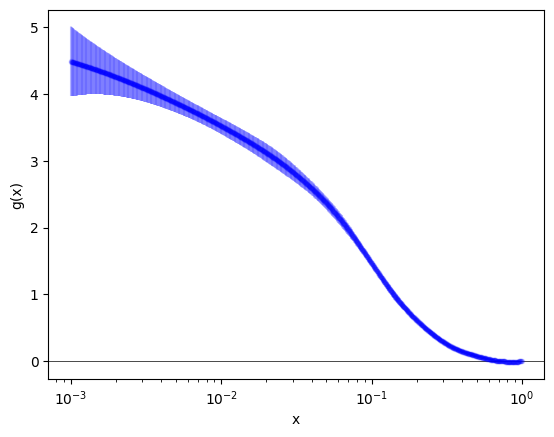

In [3]:
import matplotlib.pyplot as plt


plt.axhline(0,color='k',linewidth=0.5)
plt.errorbar(x_all, y_all, yerr_all, fmt = '.', color='b', alpha=0.15)
plt.xlabel("x")
plt.xscale("log")
plt.ylabel("g(x)")

plt.show()

# Prepare and randomize the data

In [4]:
import numpy as np

In [5]:
x_train = x_all.copy()
y_train = y_all.copy()
yerr_train = yerr_all.copy()

# Add noise to data
np.random.seed(42)
y_train += np.random.normal(0, yerr_train)

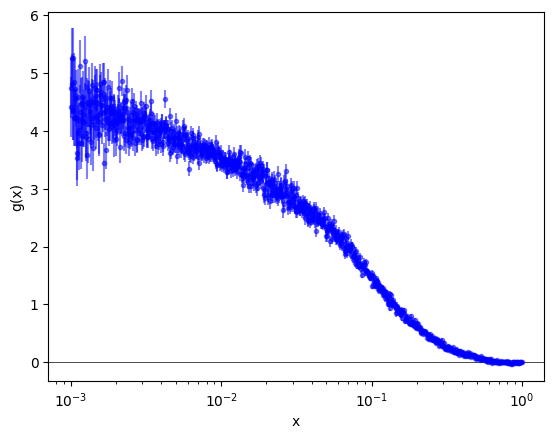

In [6]:
plt.axhline(0,color='k',linewidth=0.5)
plt.errorbar(x_train, y_train, yerr_train, fmt = '.', color='b', alpha=0.5)
plt.xlabel("x")
plt.xscale("log")
plt.ylabel("g(x)")

plt.show()

# Here we start preparing the model that can iterate hyperparameters

In [7]:
def model_builder(hp):

    model = keras.Sequential()#[normalizer])

    model.add(layers.Flatten())

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 8-16 and activations 'softmax', 'sigmoid', 'relu', 'linear'
    hp_units = hp.Int('units', min_value=8, max_value=16, step=8)
    activation = hp.Choice(name = 'activation', values = ['softmax', 'sigmoid', 'relu', 'linear'], ordered = False)
    model.add(keras.layers.Dense(units=hp_units, activation=activation))
    # add batchnorm layer after activations in the previous layer
    model.add(keras.layers.LayerNormalization(axis=1))

    # 2nd hidden layer
    hp_units2 = hp.Int('units2', min_value=8, max_value=16, step=8)
    activation2 = hp.Choice(name = 'activation2', values = ['softmax', 'sigmoid', 'relu', 'linear'], ordered = False)
    model.add(keras.layers.Dense(units=hp_units2, activation=activation2))
    # add batchnorm layer after activations in the previous layer
    model.add(keras.layers.LayerNormalization(axis=1))

    # add output layer
    activation3 = hp.Choice(name = 'activation3', values = ['softmax', 'sigmoid', 'relu', 'linear'], ordered = False)
    model.add(keras.layers.Dense(1, activation=activation3))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 1e-3])


    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse')

    return model


In [8]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.5 MB/s eta 0:00:00


Tuning is described here: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [9]:
%%time
import datetime
import keras_tuner as kt
log_dir = "logs/ai/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

tuner = kt.Hyperband(model_builder,
                     objective="loss",
                     max_epochs=30,
                     factor=3,
                     directory=log_dir,
                     project_name='gluon_auto_tuner')


# tuner = kt.RandomSearch(hypermodel=model_builder,
#                         objective='val_loss',
#                         seed=22,
#                         max_trials=100,
#                         executions_per_trial=1,
#                         directory=log_dir+'/random_search',
#                         project_name='gluon_auto_tuner')


tuner.search(x_train, y_train, epochs=50, validation_split=0.2, shuffle = True, batch_size=10,
                callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} with activation {best_hps.get('activation')} the second densely-connected
layer is {best_hps.get('units2')} with activation {best_hps.get('activation2')}. The ouput layer activation is
{best_hps.get('activation3')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 90 Complete [00h 00m 12s]
loss: 0.04275684058666229

Best loss So Far: 0.03421454131603241
Total elapsed time: 00h 06m 37s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 8 with activation sigmoid the second densely-connected
layer is 16 with activation relu. The ouput layer activation is 
linear and the optimal learning rate for the optimizer
is 0.001.

CPU times: user 5min 32s, sys: 8.26 s, total: 5min 40s
Wall time: 6min 37s


In [10]:
%%time
tuner.results_summary()

Results summary
Results in logs/ai/20230713-102135/gluon_auto_tuner
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 0072 summary
Hyperparameters:
units: 8
activation: sigmoid
units2: 16
activation2: relu
activation3: linear
learning_rate: 0.001
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0068
Score: 0.03421454131603241

Trial 0082 summary
Hyperparameters:
units: 16
activation: relu
units2: 16
activation2: relu
activation3: relu
learning_rate: 0.001
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0081
Score: 0.0375172458589077

Trial 0068 summary
Hyperparameters:
units: 8
activation: sigmoid
units2: 16
activation2: relu
activation3: linear
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0061
Score: 0.039971720427274704

Trial 0083 summary
Hyperparameters:
units: 16
activation: softmax
units2: 16
activation2: relu
activat

In [11]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 16, 'step': 8, 'sampling': 'linear'}
activation (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid', 'relu', 'linear'], 'ordered': False}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 16, 'step': 8, 'sampling': 'linear'}
activation2 (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid', 'relu', 'linear'], 'ordered': False}
activation3 (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid', 'relu', 'linear'], 'ordered': False}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}


In [14]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

In [15]:
history = model.fit(x_train, y_train, epochs=300, validation_split=0.2)

Epoch 1/300
25/25 [==============================] - 2s 16ms/step - loss: 4.8091 - val_loss: 0.1547
Epoch 2/300
25/25 [==============================] - 0s 3ms/step - loss: 0.8866 - val_loss: 0.6265
Epoch 3/300
25/25 [==============================] - 0s 4ms/step - loss: 0.3744 - val_loss: 0.4678
Epoch 4/300
25/25 [==============================] - 0s 3ms/step - loss: 0.2000 - val_loss: 0.2542
Epoch 5/300
25/25 [==============================] - 0s 3ms/step - loss: 0.1240 - val_loss: 0.1644
Epoch 6/300
25/25 [==============================] - 0s 4ms/step - loss: 0.0901 - val_loss: 0.1339
Epoch 7/300
25/25 [==============================] - 0s 3ms/step - loss: 0.0740 - val_loss: 0.1119
Epoch 8/300
25/25 [==============================] - 0s 4ms/step - loss: 0.0642 - val_loss: 0.1179
Epoch 9/300
25/25 [==============================] - 0s 4ms/step - loss: 0.0564 - val_loss: 0.1178
Epoch 10/300
25/25 [==============================] - 0s 4ms/step - loss: 0.0522 - val_loss: 0.1184
Epoch 11

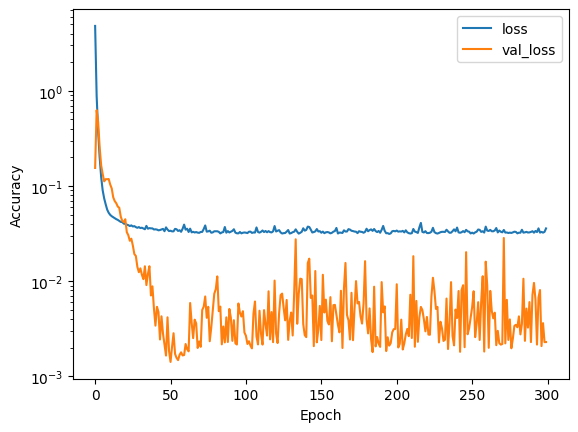

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Accuracy')
plt.legend(loc='best')

32/32 [==============================] - 0s 2ms/step


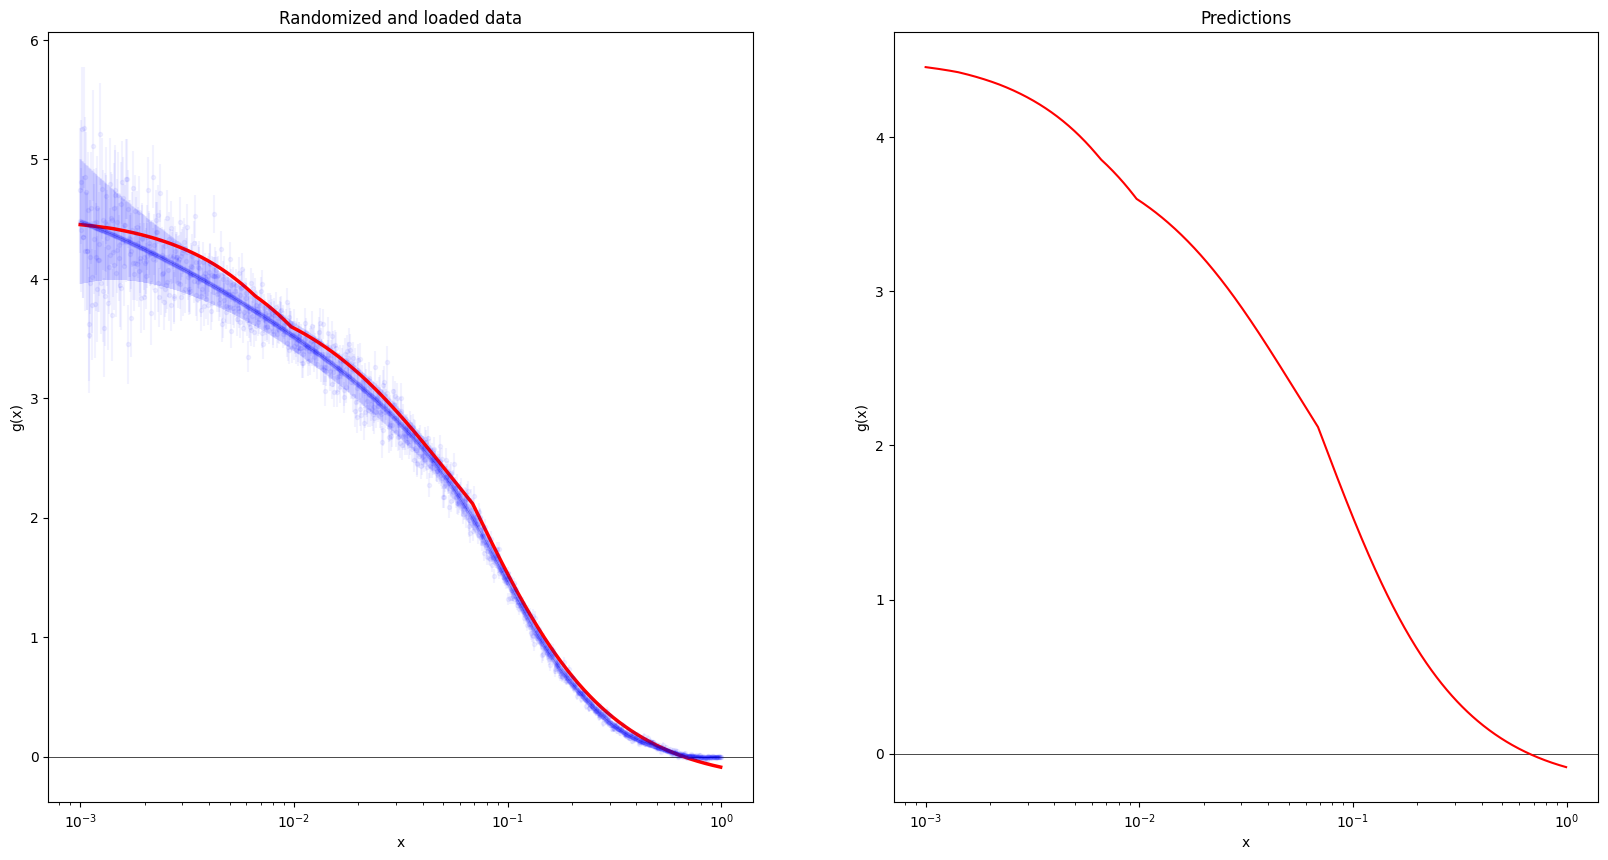

In [17]:
fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].axhline(0,color='k',linewidth=0.5)
ax[0].plot(x_all,y_all,color='darkblue',label='t', lw=0.1)
ax[0].errorbar(x_all,y_all, yerr_all, fmt = '.', color='b', alpha=0.05)
ax[0].errorbar(x_train,y_train, yerr_train, fmt = '.', color='b', alpha=0.05)
ax[0].set_title("Randomized and loaded data")
ax[0].set_xscale("log")
ax[0].set_xlabel("x")
ax[0].set_ylabel("g(x)")

  # Predictions
x_pred = x_all.to_numpy()
y_pred = model.predict(x_all).flatten() #Flatten the results in order to plot them


ax[0].plot(x_pred, y_pred, color='r', linewidth = 2.5)

# Just predictions
ax[1].axhline(0,color='k',linewidth = 0.5)
ax[1].plot(x_pred, y_pred, color='r', alpha=1)
ax[1].set_title("Predictions")
ax[1].set_xscale("log")
ax[1].set_xlabel("x")
ax[1].set_ylabel("g(x)")

plt.show()


In [24]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=3)
not_best_model = models[2]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
not_best_model.build(input_shape=(None,1))
not_best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 8)                 16        
                                                                 
 layer_normalization (LayerN  (None, 8)                16        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 layer_normalization_1 (Laye  (None, 16)               32        
 rNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [25]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
#model = tuner.hypermodel.build(best_hps)
history = not_best_model.fit(x=x_train,
                    y=y_train,
                    epochs=300,
                    validation_split=0.2,
                    batch_size=10)

Epoch 1/300
80/80 [==============================] - 3s 13ms/step - loss: 0.0388 - val_loss: 0.0017
Epoch 2/300
80/80 [==============================] - 0s 4ms/step - loss: 0.0385 - val_loss: 0.0019
Epoch 3/300
80/80 [==============================] - 0s 4ms/step - loss: 0.0384 - val_loss: 0.0032
Epoch 4/300
80/80 [==============================] - 0s 4ms/step - loss: 0.0376 - val_loss: 0.0017
Epoch 5/300
80/80 [==============================] - 0s 4ms/step - loss: 0.0395 - val_loss: 0.0154
Epoch 6/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0361 - val_loss: 0.0025
Epoch 7/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0349 - val_loss: 0.0022
Epoch 8/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0361 - val_loss: 0.0044
Epoch 9/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0361 - val_loss: 0.0022
Epoch 10/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0387 - val_loss: 0.0033
Epoch 11

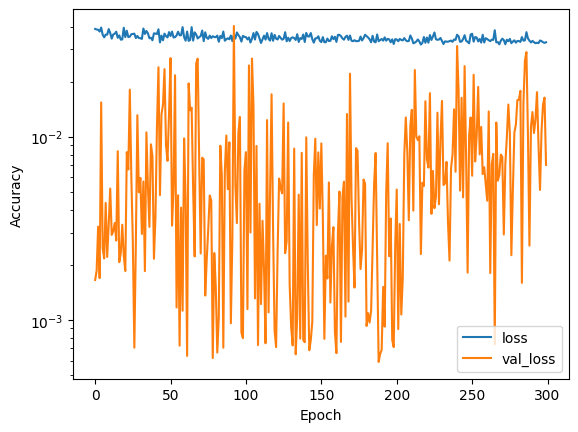

In [26]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yscale('log')
plt.legend(loc='best')

32/32 [==============================] - 0s 2ms/step


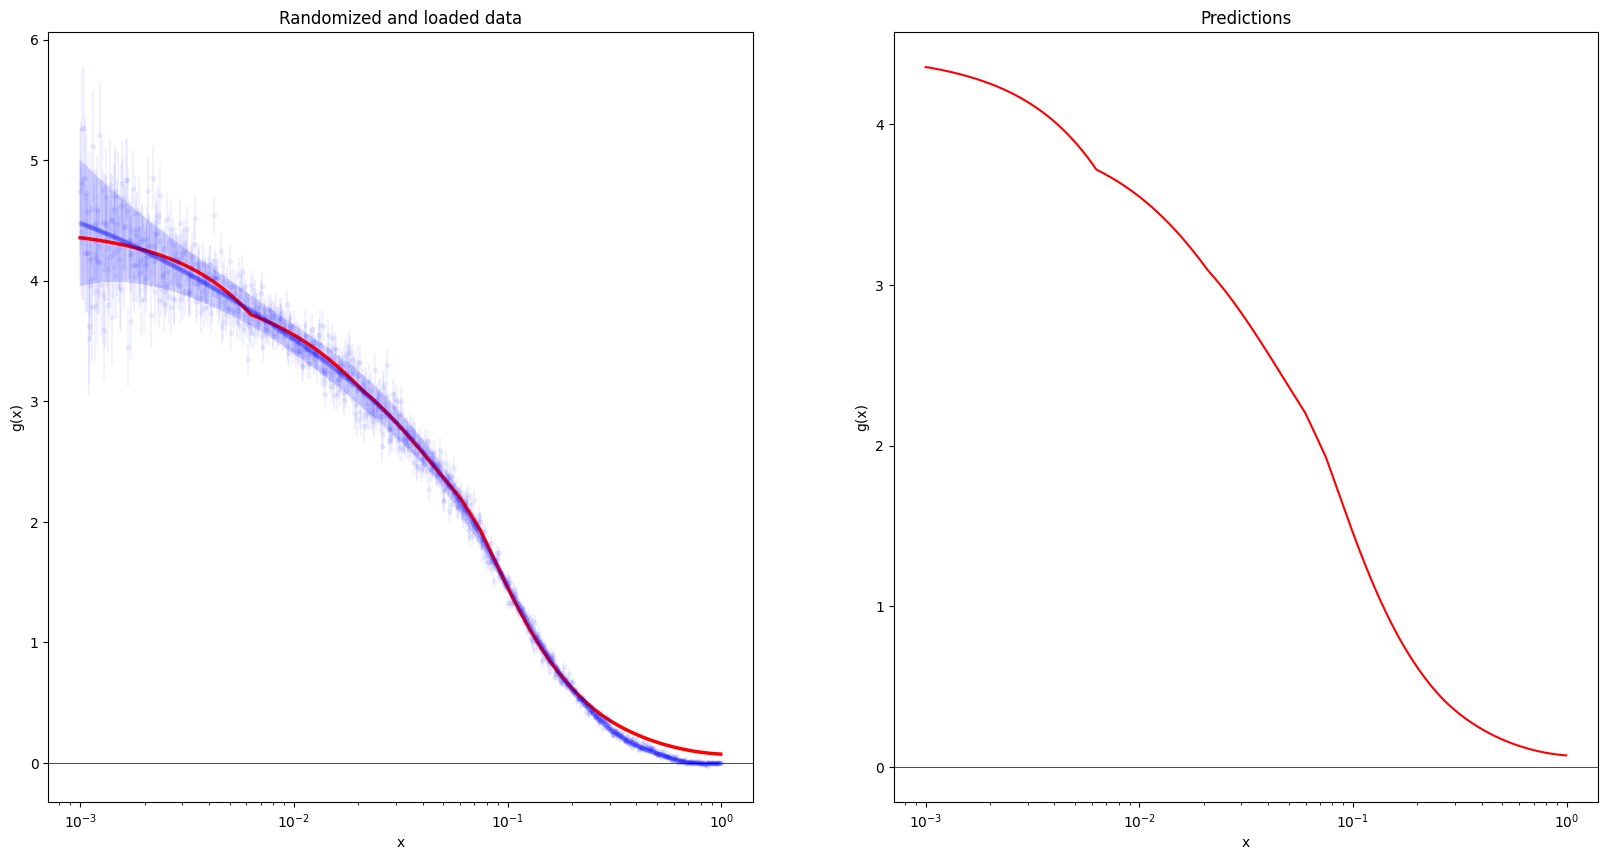

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].axhline(0,color='k',linewidth=0.5)
ax[0].plot(x_all,y_all,color='darkblue',label='t', lw=0.1)
ax[0].errorbar(x_all,y_all, yerr_all, fmt = '.', color='b', alpha=0.05)
ax[0].errorbar(x_train,y_train, yerr_train, fmt = '.', color='b', alpha=0.05)
ax[0].set_title("Randomized and loaded data")
ax[0].set_xscale("log")
ax[0].set_xlabel("x")
ax[0].set_ylabel("g(x)")

  # Predictions
x_pred = x_all.to_numpy()
y_pred = not_best_model.predict(x_all).flatten() #Flatten the results in order to plot them


ax[0].plot(x_pred, y_pred, color='r', linewidth = 2.5)

# Just predictions
ax[1].axhline(0,color='k',linewidth = 0.5)
ax[1].plot(x_pred, y_pred, color='r', alpha=1)
ax[1].set_title("Predictions")
ax[1].set_xscale("log")
ax[1].set_xlabel("x")
ax[1].set_ylabel("g(x)")

plt.show()
